In [1]:
import numpy as np
import pickle
import os
import time
import shutil
import sys
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from statsmodels.stats.contingency_tables import mcnemar

LOAD_FROM_PICKLE = True

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

USE_GPU = True

In [2]:
# The kernel needs to be restarted before changing this setting to take effect

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Tensorflow import needs to be after setting the CUDA_VISIBLE_DEVICES

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Activation, Input, Input, Conv1D, Conv2D, MaxPooling1D
from tensorflow.python.keras.layers import MaxPooling2D, Dense, Dropout, Activation, Flatten, InputLayer
from tensorflow.python.keras.layers import concatenate, Reshape, Lambda, Add, Multiply, Average, Subtract
from tensorflow.keras.layers import Normalization, RandomRotation, RandomTranslation, RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")


Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


In [4]:
path = '../Data/AllBirds/'

# get total number of images in AllBirds
num_images = len(os.listdir(path))
print(f"Total number of images: {num_images}")

filenames = []
labels = np.zeros((num_images, 1), dtype=np.uint16)
labels_dict = {}

counter = 0
for i, filename in enumerate(os.listdir(path)):
    filenames.append(filename)
    label = filename.split('-')[0]
    if label not in labels_dict:
        labels_dict[label] = counter
        counter += 1
    labels[i] = labels_dict[label]

print(f"Number of classes: {counter}")
print(f"Shape of labels: {labels.shape}")

Total number of images: 63000
Number of classes: 450
Shape of labels: (63000, 1)


Above, each filename is saved and processed to extract class information. The dataset has a total of 63,000 images spanning 450 different types of birds. The large number of classes means there is a 0.2% chance to select the correct class at random. Throughout this lab I will be using accuracy as my metric for evaluating model performance. This is based on a use case of an app that can identify the species of a bird from a picture. For this use case every class hold the same amount of weight and the value in correctly identifying a bird is the same as the value lost when mis-identiying one.

In [5]:
# import multithreading
from multiprocessing import Pool

def Augment_Image(filename, path, save_path):
    img = cv.imread(path + filename)
    img = cv.resize(img, (32, 32))

    # save the image
    cv.imwrite(save_path + filename, img)



def Augment_Data(X_train_filenames, path):
    # clear the directory AllBirds_Augmented
    if os.path.exists('../Data/AllBirds_Augmented'):
        shutil.rmtree('../Data/AllBirds_Augmented')
    os.mkdir('../Data/AllBirds_Augmented')

    # load the images as floats and augment them
    with Pool() as p:
        p.starmap(Augment_Image, [(filename, path, '../Data/AllBirds_Augmented/') for filename in X_train_filenames])
        
    return

# Augment_Data(filenames, path)

The above code takes all my initial images and downsizes them at a ratio of 7 to 1 in both the x and y axis. This was only done once and then saved. The original image size is 224x224 which divides evenly down to a size of 32x32. Through some basic testing I did not find that the size of the image had a significant impact on the accuracy of the model but had major impacts to the size of files in memory and training times. I also messed with the idea of baking augmentations into the shrunk versions of the images but eventually decided agianst it in favor of doing it in the generator. Creating the augmentations in the generator is signifigantly slower but comes with the benifit of rerandomizing the augmentations on each epoch.

In [6]:
# saving the filename array as .npy file
np.save('filenames.npy', filenames)

# One hot vector representation of labels
y_labels_one_hot = to_categorical(labels)

# saving the y_labels_one_hot array as a .npy file
np.save('y_labels_one_hot.npy', y_labels_one_hot)

This one hot encodes the labels and stores them along with the image names.

In [7]:
filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('filenames_shuffled.npy', filenames_shuffled)

The names and labels are shuffled and then saved

In [8]:
# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, stratify=y_labels_one_hot_shuffled)

print(f"Shape of X_train_filenames: {X_train_filenames.shape}")
print(f"Shape of X_test_filenames: {X_test_filenames.shape}")

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# saving the X_train_filenames, X_test_filenames, y_train, y_test arrays as .npy files
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', y_train)

np.save('X_test_filenames.npy', X_test_filenames)
np.save('y_test.npy', y_test)

Shape of X_train_filenames: (50400,)
Shape of X_test_filenames: (12600,)
Shape of y_train: (50400, 450)
Shape of y_test: (12600, 450)


Here the data is split 80/20 into training and testing. Because of the large size of the dataset (< 50,000), an 80/20 split is a good choice. In the split, the data is stratified by class to ensure that the training and testing sets have the same distribution of classes.

In [9]:
def mcnemar_test(y_test, yhat1, yhat2, name1, name2):
    # create a bitmasks for each of the above
    model1_correct = np.equal(y_test, yhat1)
    model2_correct = np.equal(y_test, yhat2)

    both_correct = np.logical_and(model1_correct, model2_correct)
    both_wrong = np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct))
    model1_correct_model2_wrong = np.logical_and(model1_correct, np.logical_not(model2_correct))
    model2_correct_model1_wrong = np.logical_and(model2_correct, np.logical_not(model1_correct))

    # create the contingency table
    # table = np.array([[np.sum(both_right), np.sum(just_yhat1_right)], [np.sum(just_yhat2_right), np.sum(both_wrong)]])
    table = np.array([[np.sum(both_correct), np.sum(model1_correct_model2_wrong)], [np.sum(model2_correct_model1_wrong), np.sum(both_wrong)]])
    # print(f'Contingency table for {name1} and {name2}')
    # print(table)
    
    # calculate the mcnemar test
    result = mcnemar(table, exact=True)
    # calculate the significance
    p = result.pvalue
    # interpret the p-value
    alpha = 0.05

    p_str = str(round(p, 5)).ljust(7, '0')

    if p > alpha:
        print(f'p-value = {p_str} > {alpha} (alpha). Fail to reject the null hypothesis (H0), that there is no signifigant difference between {name1} and {name2}')
    else:
        print(f'p-value = {p_str} < {alpha} (alpha). Reject H0. There is a significant difference between {name1} and {name2}')

def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

def plot_ROC_curve_multiclass(y_test, yhat, model_names):
    plt.figure(figsize=(10, 10))

    n_classes = y_test.shape[1]

    # for each model, plot the average ROC curve like above
    for idx in range(len(yhat)):
        # get the fpr and tpr for each class for this model
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = mt.roc_curve(y_test[:, i], yhat[idx][:, i])
            roc_auc[i] = mt.auc(fpr[i], tpr[i])

        # compute the micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = mt.roc_curve(y_test.ravel(), yhat[idx].ravel())
        roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

        # plot the average ROC curve
        plt.plot(fpr["micro"], tpr["micro"], label=f'{model_names[idx]} (area = %0.3f)' % roc_auc["micro"], linewidth=.75)


    plt.plot([0, 1], [0, 1], color='navy', lw=.75, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Avreage ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

Above are helper functions used for running test and plotting graphs from completed models

In [10]:
class Bird_Generator(keras.utils.Sequence) :

	def __init__(self, path, image_filenames, labels, batch_size):
		self.path = path
		self.image_filenames = image_filenames
		self.labels = labels
		self.batch_size = batch_size

	def __len__(self) :
		return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

	def load_normalize_image(self, image_name):
		image = cv.imread(self.path + image_name)
		image = image / 255.0 - 0.5

		image = tf.keras.preprocessing.image.random_rotation(image, 5, row_axis=0, col_axis=1, channel_axis=2)
		image = tf.keras.preprocessing.image.random_shift(image, 0.075, 0.075, row_axis=0, col_axis=1, channel_axis=2)
		return image

	def __getitem__(self, idx) :
		batch_x_names = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
		batch_y = np.array(self.labels[idx * self.batch_size : (idx+1) * self.batch_size])

		batch_x = np.array([self.load_normalize_image(image_name) for image_name in batch_x_names])

		return batch_x, batch_y

Beacuse I selected to use a large dataset I was unable to load all of it into memory at once. After [many hours of] my kernal crashing I realized I needed to use a data generator instead of directly loading the images all at once. The generator loads inamges inbatches to give to the model. As each picture is loaded it is also normalized and the mean is subtracted. The generator also performs the data expansion in the form of a random rotation and shifts. I selected these two because all of the images were previously cropped to have the bird upright in the middle of the image. These augmentations help to ensure that the model is not overfitting to the specific crop of the image and improve the ability of the model to generalize to new images. This generator went through many iterations that can no longer be seen here in attempts to speed it up. Ultimately I believe that loading and augmenting the images in the generator is the bottleneck in the training process. 

In [11]:
def create_convolutional_model(num_filters, kernel_sizes, pool_sizes, name, additional_dense_layer=False, dense_layer_size=0):
    model = Sequential(name=name)

    for i in range(len(num_filters)):
        if i == 0:
            model.add(Conv2D(num_filters[i], kernel_sizes[i], activation='relu', input_shape=(32, 32, 3)))
        else:
            model.add(Conv2D(num_filters[i], kernel_sizes[i], activation='relu'))
        model.add(MaxPooling2D(pool_sizes[i]))

    model.add(Dropout(0.25))

    model.add(Flatten())

    if additional_dense_layer:
        model.add(Dense(dense_layer_size, activation='relu'))

    model.add(Dense(450, activation = "softmax")) #Classification layer or output layer

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    model.build(input_shape=(None, 32, 32, 3))

    return model

This function is used to create convolutional neural networks with a variable number of filters, kernel size, and max pooling size. There is also an option to add an additional dense layer after the convolutions but before the output layer.

In [12]:
CNN1_params = {
    'num_filters': [32, 16],
    'kernel_sizes': [4, 2],
    'pool_sizes': [4, 2],
    'name': "CNN1"
}

CNN2_params = {
    'num_filters': [32, 16, 8],
    'kernel_sizes': [4, 2, 1],
    'pool_sizes': [4, 2, 1],
    'name': "CNN2"
}

CNN3_params = {
    'num_filters': [64, 32],
    'kernel_sizes': [2, 2],
    'pool_sizes': [2, 2],
    'name': "CNN3"
}

CNN4_params = {
    'num_filters': [32, 16],
    'kernel_sizes': [6, 4],
    'pool_sizes': [3, 2],
    'name': "CNN4"
}

CNN5_params = {
    'num_filters': [32, 16],
    'kernel_sizes': [4, 2],
    'pool_sizes': [4, 2],
    'name': "CNN5",
    'additional_dense_layer': True,
    'dense_layer_size': 128
}

CNN6_params = {
    'num_filters': [32, 16],
    'kernel_sizes': [4, 2],
    'pool_sizes': [4, 2],
    'name': "CNN6",
    'additional_dense_layer': True,
    'dense_layer_size': 450
}

models = []

models.append(create_convolutional_model(**CNN1_params))
models.append(create_convolutional_model(**CNN2_params))
models.append(create_convolutional_model(**CNN3_params))
models.append(create_convolutional_model(**CNN4_params))
models.append(create_convolutional_model(**CNN5_params))
models.append(create_convolutional_model(**CNN6_params))

Here the parameters for all the modles are set and the models are created. I used a variety of options for all the parameters to get a diverse view of how different modles performed. The last two models also utilize the additional dense layer where I explore how the size effects the performance.

In [13]:
batch_size = 1024

path = '../Data/AllBirds_Augmented/'

my_training_batch_generator = Bird_Generator(path, X_train_filenames, y_train, batch_size)
my_test_batch_generator = Bird_Generator(path, X_test_filenames, y_test, batch_size)

steps_per_epoch = my_training_batch_generator.__len__()
validation_steps = my_test_batch_generator.__len__()

model_params = {
    'x': my_training_batch_generator,
    'steps_per_epoch': steps_per_epoch,
    'epochs': 50,
    'validation_data': my_test_batch_generator,
    'validation_steps': validation_steps,
    'verbose': 0
}

The generators for both testing and training are created above and used by all models. The parameters for the generators are also set so they will be the same accross all models.

In [14]:
LOAD_STORED_MODELS = False

if LOAD_STORED_MODELS:
    for model in models:
        # load model
        model.load_weights(f"Models/{model.name}-{model_params['epochs']}.h5")
        #load history
        with open(f"Models/{model.name}-{model_params['epochs']}.pk1", 'rb') as file_pi:
            model.history = pickle.load(file_pi)
else:
    for model in models:
        start = time.time()

        history = model.fit(**model_params)

        print(f"Model {model.name} took {round(time.time() - start, 2)} seconds to train")

        # Save model
        model.save_weights(f"Models/{model.name}-{model_params['epochs']}.h5")
        # save history
        with open(f"Models/{model.name}-{model_params['epochs']}.pkl", 'wb') as f:
            pickle.dump(history.history, f)

        print(f"Model {model.name} saved")


Model CNN1 took 1271.25 seconds to train
Model CNN1 saved
Model CNN2 took 1281.51 seconds to train
Model CNN2 saved
Model CNN3 took 1327.56 seconds to train
Model CNN3 saved
Model CNN4 took 1306.72 seconds to train
Model CNN4 saved
Model CNN5 took 1312.85 seconds to train
Model CNN5 saved
Model CNN6 took 1321.51 seconds to train
Model CNN6 saved


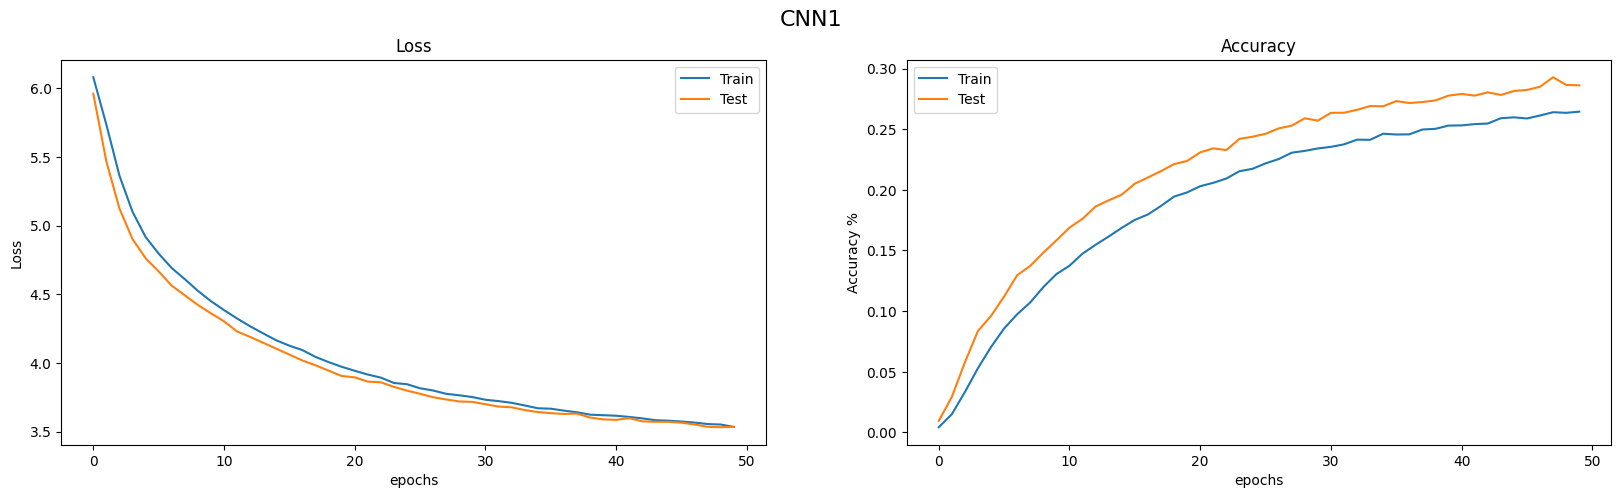

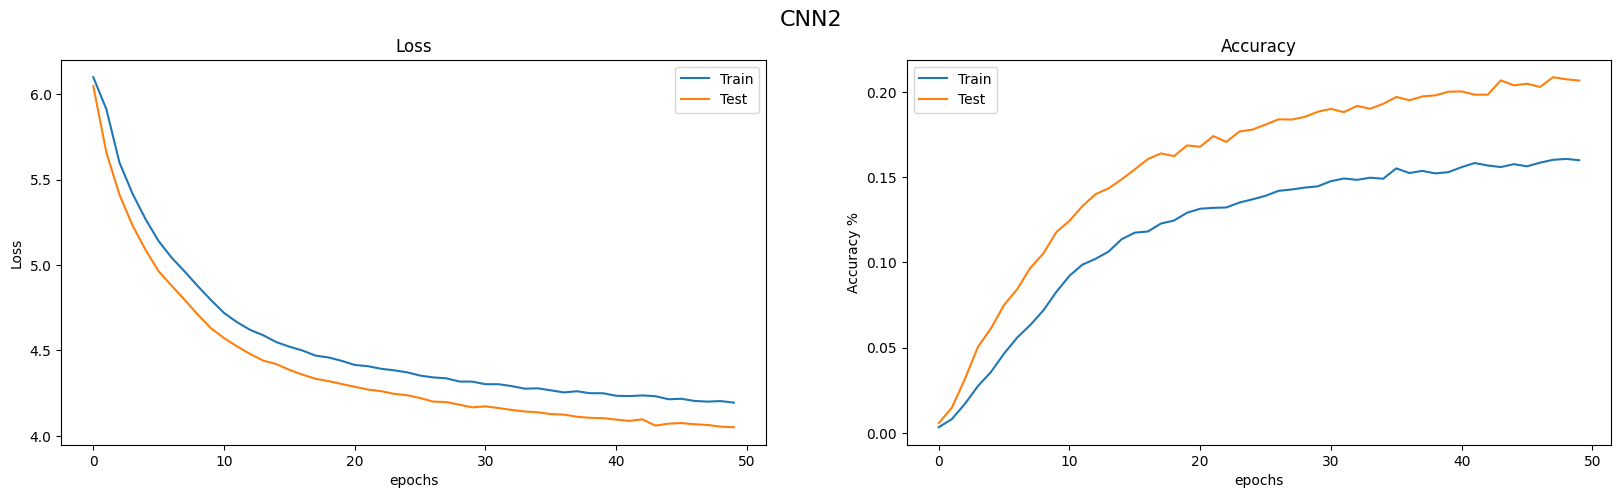

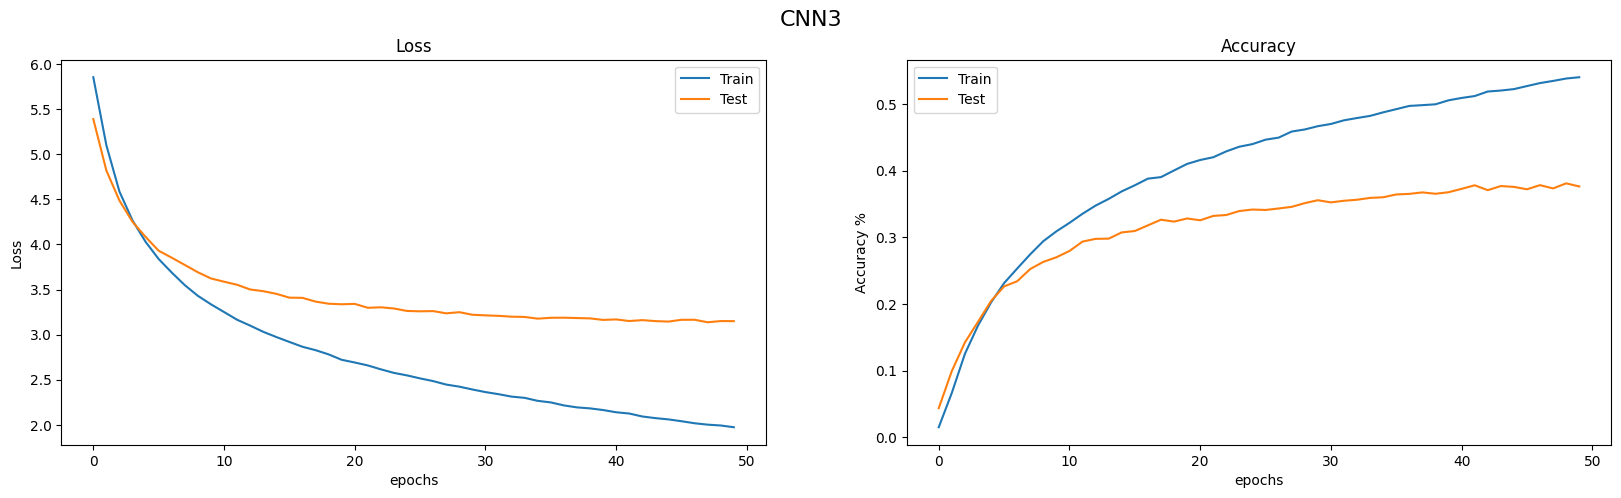

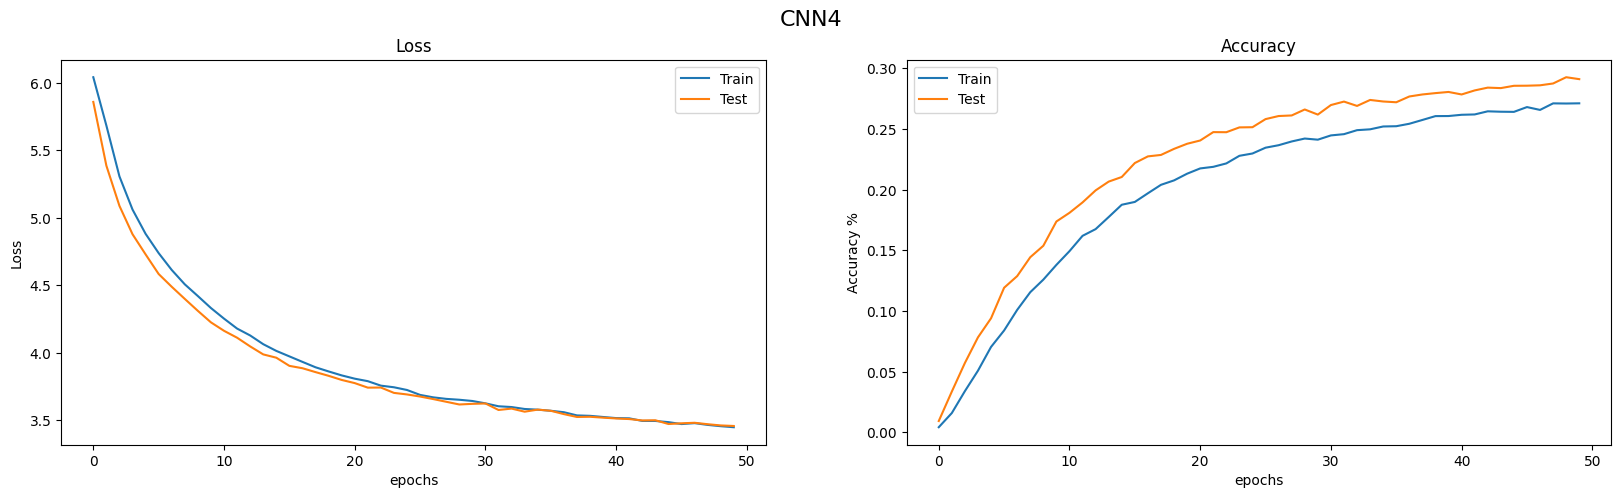

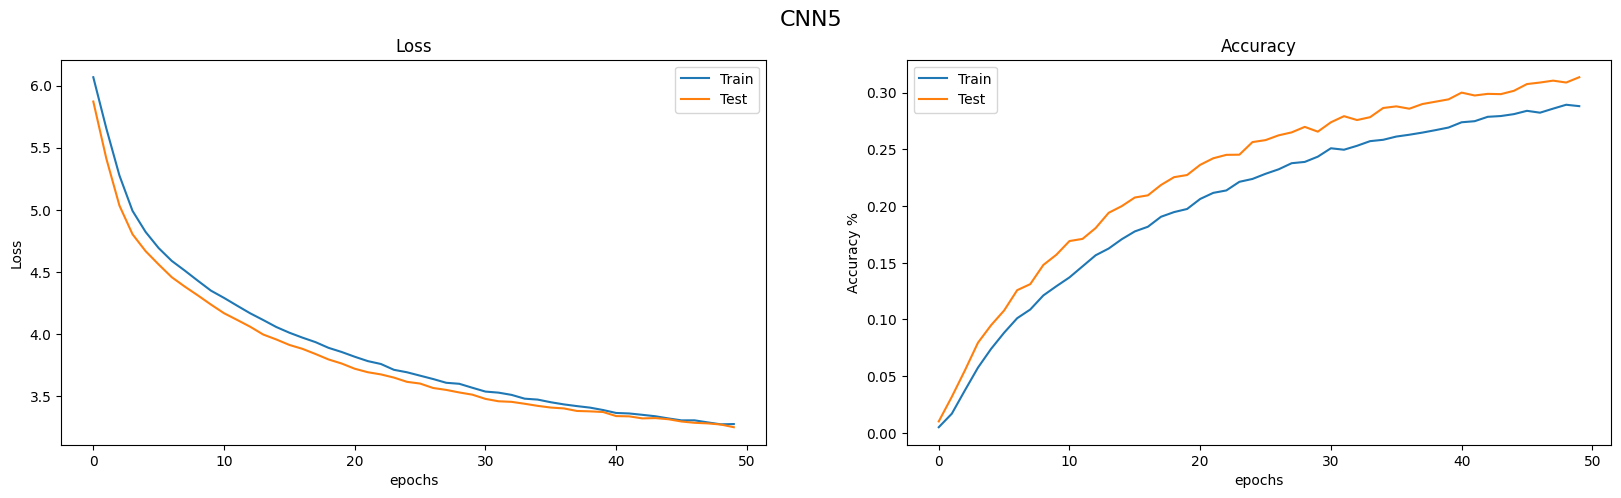

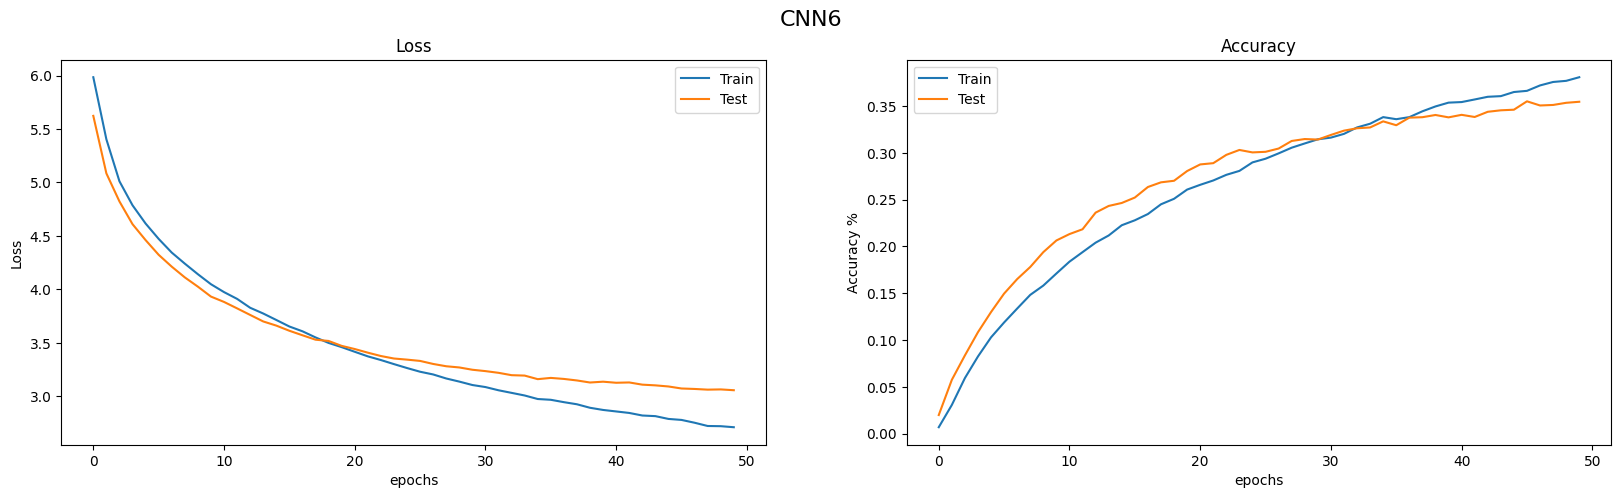

In [16]:
for model in models:
    plot_history(model.history, model.name)

Each model was run for 50 epochs and converged. Different models reached different levels of convergence but I wanted to keep the epochs even so they could be fairly comapred.

In [17]:
yhat_probs = []

for model in models:
    yhat_probs.append(model.predict(my_test_batch_generator))

yhat_predicitions = []
for yhat_prob in yhat_probs:
    yhat_predicitions.append(np.argmax(yhat_prob, axis=1).flatten())

y_test_max = y_test.argmax(axis=-1)
y_test_max = y_test_max.flatten()

13/13 [==============================] - 5s 408ms/step


The proabilities for the test set are generated and the highest probability is selected as the predicted class. The accuracy is then calculated and the confusion matrix is plotted

In [18]:
# run mcnemar test for each unique pair of models
for i in range(len(models)):
    for j in range(i+1, len(models)):
        print(f'Mcnemar test for {models[i].name} and {models[j].name}:')
        mcnemar_test(y_test_max, yhat_predicitions[i], yhat_predicitions[j], models[i].name, models[j].name)

Mcnemar test for CNN1 and CNN2:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN1 and CNN2
Mcnemar test for CNN1 and CNN3:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN1 and CNN3
Mcnemar test for CNN1 and CNN4:
p-value = 0.04358 < 0.05 (alpha). Reject H0. There is a significant difference between CNN1 and CNN4
Mcnemar test for CNN1 and CNN5:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN1 and CNN5
Mcnemar test for CNN1 and CNN6:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN1 and CNN6
Mcnemar test for CNN2 and CNN3:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN2 and CNN3
Mcnemar test for CNN2 and CNN4:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between CNN2 and CNN4
Mcnemar test for CNN2 and CNN5:
p-value = 0.00000 < 0.05 (alpha). Rej

By running a mcneamar test on every pair of models I can say with a high level of confidence that they are all different from one another. This means that I can use my selected metric as in indicator for which model is best.

In [19]:
# evaluate the models
for model in models:
    print(f"Model {model.name} has a test accuracy of {round(model.evaluate(my_test_batch_generator)[1], 4)}")

13/13 [==============================] - 6s 416ms/step - loss: 3.5291 - accuracy: 0.2900
Model CNN1 has a test accuracy of 0.29
13/13 [==============================] - 5s 401ms/step - loss: 4.0391 - accuracy: 0.2073
Model CNN2 has a test accuracy of 0.2073
13/13 [==============================] - 5s 397ms/step - loss: 3.1250 - accuracy: 0.3759
Model CNN3 has a test accuracy of 0.3759
13/13 [==============================] - 5s 395ms/step - loss: 3.4318 - accuracy: 0.2908
Model CNN4 has a test accuracy of 0.2908
13/13 [==============================] - 5s 402ms/step - loss: 3.2561 - accuracy: 0.3140
Model CNN5 has a test accuracy of 0.314
13/13 [==============================] - 5s 404ms/step - loss: 3.0611 - accuracy: 0.3517
Model CNN6 has a test accuracy of 0.3517


The accuracy of each model is calculated for the test set. Model 3 performed the best. This model had the smallest Max Pool sizes and it is possible that this allowed it to learn more complex features by throwing out less data.

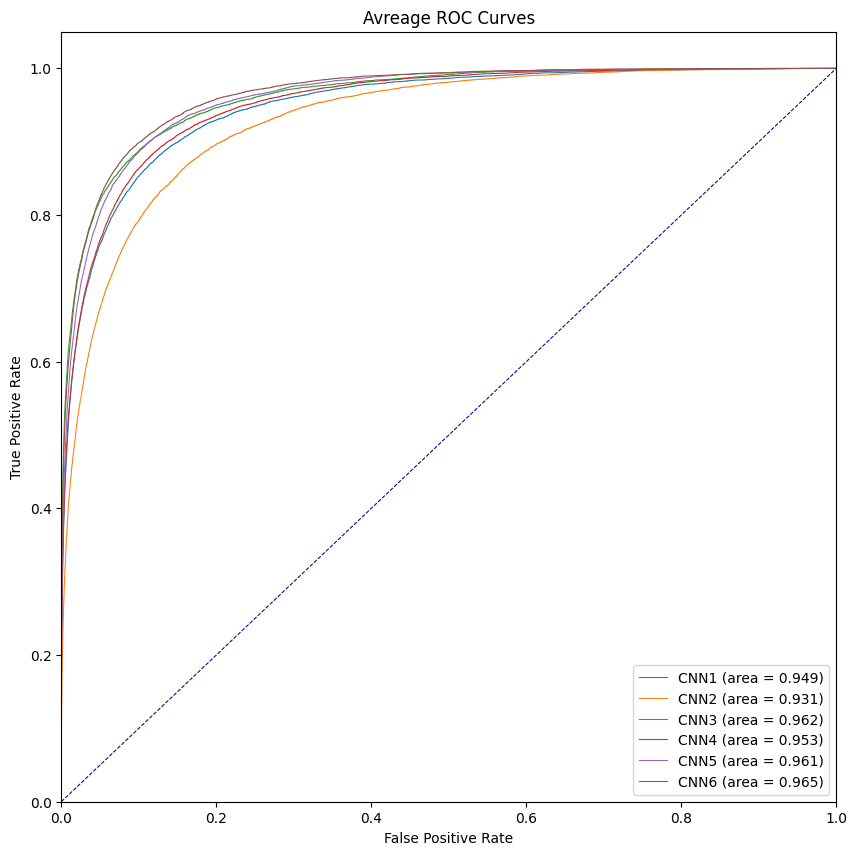

In [21]:
# takes the y_test and the yhat_probabilities and model names
plot_ROC_curve_multiclass(y_test, yhat_probs, [model.name for model in models])

Dispite model 3 having the best accuracy, model 6 has the best looking ROC curve and the highest AUC. The main difference in this model was the additional large dense layer that may have helped in making final predictions.

In [22]:
# make a normal MLP model and train it on the augmented data

def create_MLP_model(name):
    model = Sequential(name=name)

    model.add(Flatten())

    model.add(Dense(1000, activation = "relu"))
    model.add(Dense(500, activation = "relu"))
    model.add(Dropout(0.25))

    model.add(Dense(450, activation = "softmax")) #Classification layer or output layer

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    K.set_value(model.optimizer.learning_rate, 0.01)

    model.build(input_shape=(None, 32, 32, 3))

    return model

MLP_model = create_MLP_model("MLP")

hist = MLP_model.fit(**model_params)

# save model
MLP_model.save_weights(f"Models/{MLP_model.name}-{model_params['epochs']}.h5")

# save history
with open(f"Models/{MLP_model.name}-{model_params['epochs']}.pkl", 'wb') as f:
    pickle.dump(hist.history, f)

Finally, a normal MLP model is created and trained to compare performance with the best CNN models.

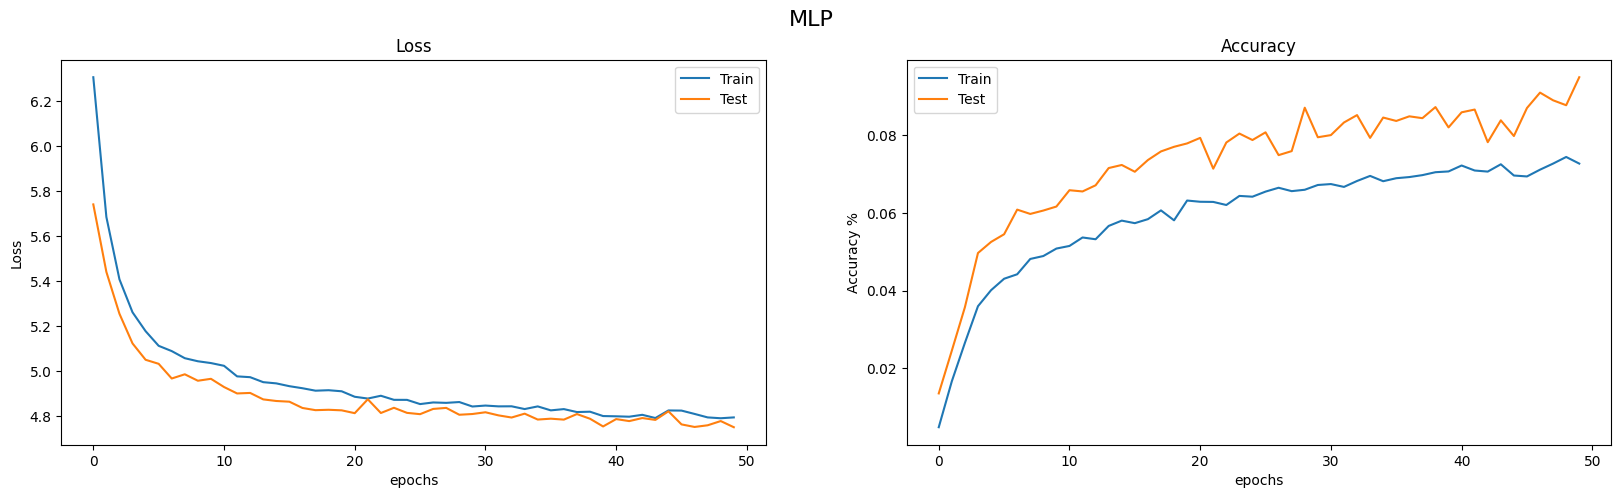

In [23]:
plot_history(hist, MLP_model.name)

The MLP converged within 50 epochs

13/13 [==============================] - 5s 402ms/step - loss: 4.7492 - accuracy: 0.0923
Model MLP has a test accuracy of 0.0923
13/13 [==============================] - 5s 401ms/step
Mcnemar test for MLP and CNN3:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between MLP and CNN3
Mcnemar test for MLP and CNN6:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between MLP and CNN6


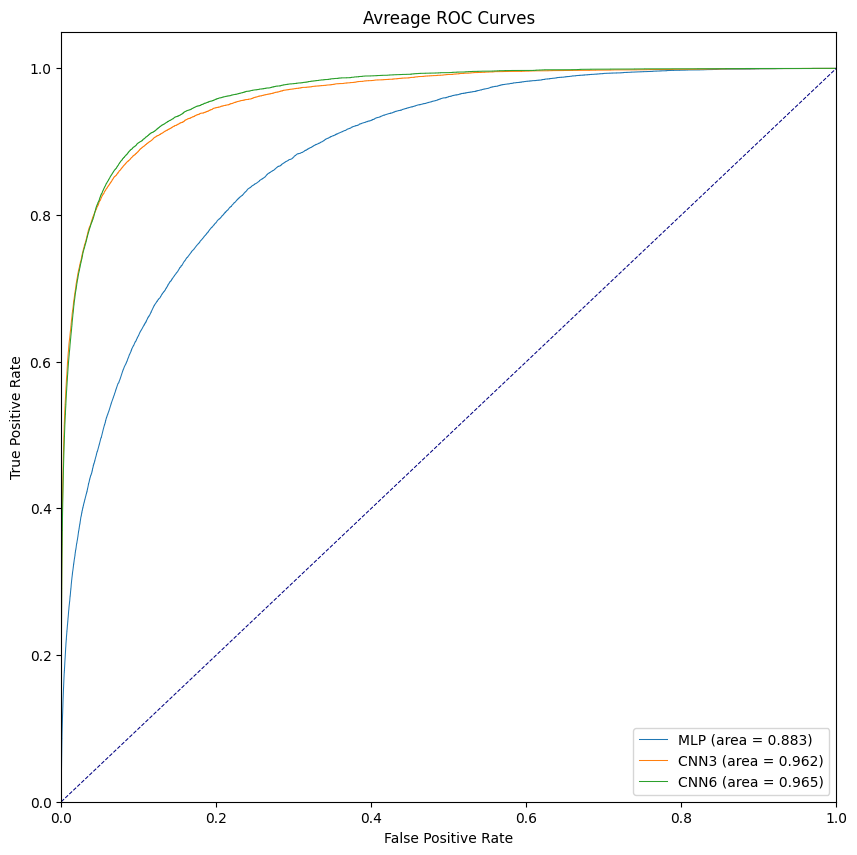

In [25]:
# evaluate the model
print(f"Model {MLP_model.name} has a test accuracy of {round(MLP_model.evaluate(my_test_batch_generator)[1], 4)}")

mlp_probs = MLP_model.predict(my_test_batch_generator)
mlp_predictions = np.argmax(mlp_probs, axis=1).flatten()

# run mcnemar test for mlp and CNN3 and CNN6
print(f'Mcnemar test for {MLP_model.name} and {models[2].name}:')
mcnemar_test(y_test_max, mlp_predictions, yhat_predicitions[2], MLP_model.name, models[2].name)

print(f'Mcnemar test for {MLP_model.name} and {models[5].name}:')
mcnemar_test(y_test_max, mlp_predictions, yhat_predicitions[5], MLP_model.name, models[5].name)

# plot ROC curve for MLP and CNN3 and CNN6
plot_ROC_curve_multiclass(y_test, [mlp_probs, yhat_probs[2], yhat_probs[5]], [MLP_model.name, models[2].name, models[5].name])

Here the MLP is shown to be statistacly different from CNN3 and CNN6. Howerver, given the same epochs, the MLP did not perform as well as the CNNs. As can be seen in the ROC curves both the CNN's dominate the MLP.

I decided to use the combination of two additioanl models and the custom generator I created in order to use the larger dataset as my exceptional work